# Grid sag

#### Demonstrates the use of the `grid sag` surface in PAOS


First let's create a grid sag defined by Zernike polynomials on an elliptical aperture.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from paos import WFO
from paos.core.run import push_results
from paos.core.plot import simple_plot

In [2]:
beam_diameter = 1.1
grid_size = 1024
zoom = 4
wavelength = 1.0
xdec = ydec = 0.0

lens_fl=1.0
dz=1.0

retval1 = {}

wfo = WFO(beam_diameter, 1.0e-6 * wavelength, grid_size, zoom)
wfo.aperture(xc=xdec, yc=ydec, r=beam_diameter / 2, shape="circular")
wfo.make_stop()

index = np.arange(0, 6)
Z = np.array(
    [
        0,
        0,
        0,
        0.0,
        200.0,
        0.0,
    ]
)

Z *= 1.0e-9 * wavelength

ordering = "standard"
normalize = True
radius = 0.55

wfe = wfo.zernikes(index, Z, ordering, normalize, radius)

retval1[0] = push_results(wfo)
retval1[0]["aperture"] = None
retval1[0]["ABCDt"] = lambda: None

# roll the WFE by n pixels on both axes
shift = 0
wfe = np.roll(wfe, shift, axis=(0, 1))

# change the WFE sampling when saving
from skimage.transform import rescale
scale_x = 0.9
scale_y = 1.1
wfe = rescale(
    wfe,
    scale=(scale_y, scale_x),
    anti_aliasing=(
        scale_x < 1.0 or scale_y < 1.0
    ),  # anti_aliasing is required for downsampling
    cval=np.nan,
    order=3,
)

out_dict = {
    "data": wfe,
    "nx": wfo._wfo.shape[1],
    "ny": wfo._wfo.shape[0],
    "delx": wfo.dx / scale_x,
    "dely": wfo.dy / scale_y,
    "xdec": shift,
    "ydec": shift,
}
np.save("sag.npy", out_dict)


wfo.lens(lens_fl=lens_fl)
wfo.propagate(dz=dz)

retval1[1] = push_results(wfo)
retval1[1]["aperture"] = None
retval1[1]["ABCDt"] = lambda: None

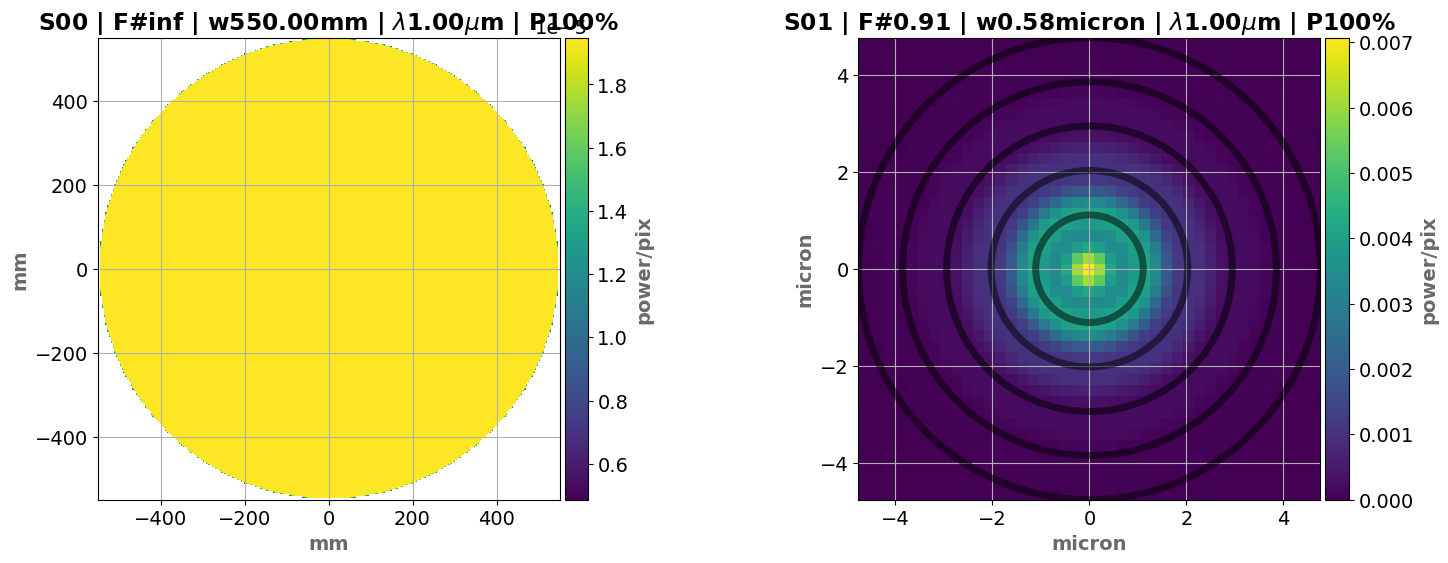

WFE RMS: 44.11 nm
WFE PV: 692.82 nm


In [3]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

simple_plot(fig, ax0, key=0, item=retval1[0], ima_scale="linear")
simple_plot(fig, ax1, key=1, item=retval1[1], ima_scale="linear")
plt.show()

print(f"WFE RMS: {1e9 * np.std(wfe):.2f} nm")
print(f"WFE PV: {1e9 * np.ptp(wfe):.2f} nm")

Now use grid sag


In [4]:
wfo = WFO(beam_diameter, 1.0e-6 * wavelength, grid_size, zoom)
wfo.aperture(xc=xdec, yc=ydec, r=beam_diameter / 2, shape="circular")
wfo.make_stop()

data = np.load("sag.npy", allow_pickle=True).item()

sag, nx, ny, delx, dely, xdec, ydec = (
    data["data"],
    data["nx"],
    data["ny"],
    data["delx"],
    data["dely"],
    data["xdec"],
    data["ydec"],
)

sag = wfo.grid_sag(sag, nx, ny, delx, dely, xdec, ydec)

retval2 = {}
retval2[0] = push_results(wfo)
retval2[0]["aperture"] = None
retval2[0]["ABCDt"] = lambda: None

wfo.lens(lens_fl=lens_fl)
wfo.propagate(dz=dz)

retval2[1] = push_results(wfo)
retval2[1]["aperture"] = None
retval2[1]["ABCDt"] = lambda: None

(0, 0) (0, 0)


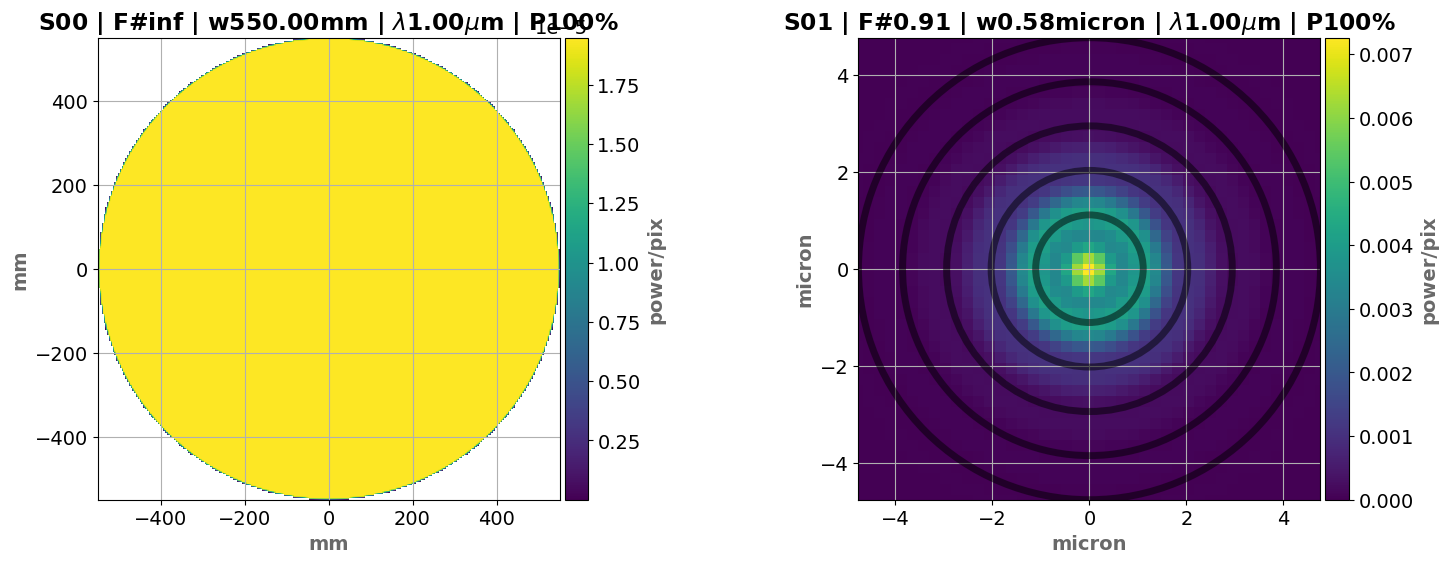

In [5]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

simple_plot(fig, ax0, key=0, item=retval2[0], ima_scale="linear")
simple_plot(fig, ax1, key=1, item=retval2[1], ima_scale="linear")
plt.show()

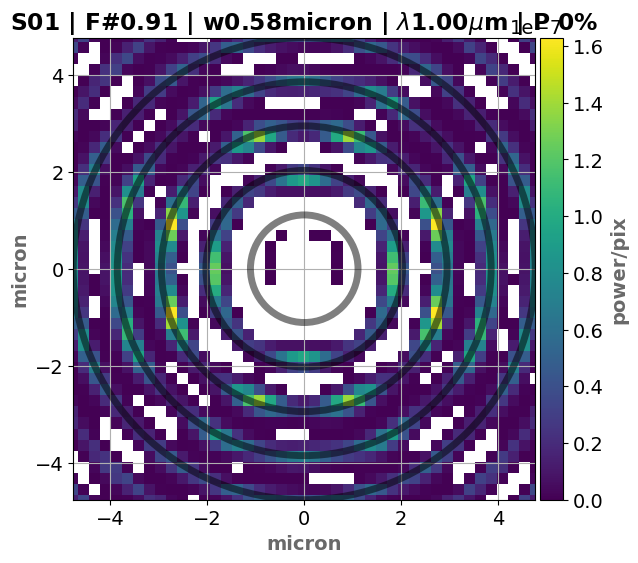

In [6]:
retval_diff = retval2.copy()

amp1 = retval1[1]["amplitude"]
amp2 = retval2[1]["amplitude"]

dnx = amp2.shape[1] - amp1.shape[1]
dny = amp2.shape[0] - amp1.shape[0]

padx, pady = dnx // 2, dny // 2
padx = (padx, padx) if dnx % 2 == 0 else (padx, padx + 1)
pady = (pady, pady) if dny % 2 == 0 else (pady, pady + 1)

if dnx >= 0 and dny >= 0:  # pad with zeros at edges
    amp1 = np.pad(amp1, (padx, pady), mode='constant', constant_values=0)
elif dnx < 0 and dny < 0:  # crop at edges
    cropx, cropy = - np.array(padx), - np.array(pady)
    amp1 = amp1[cropx[0]:-cropx[1], cropy[0]:-cropy[1]]
else:
    raise ValueError("Unforeseen dimension mismatch")

retval_diff[1]["amplitude"] = amp1 - amp2

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
simple_plot(fig, ax0, key=1, item=retval_diff[1], ima_scale="linear")
plt.show()

Now use the run function directly